In [1]:
%matplotlib inline
%reload_ext autoreload
%autoreload 2

In [4]:
from tomopt.muon import *
from tomopt.inference import *
from tomopt.volume import *
from tomopt.core import *
from tomopt.optimisation import *

import matplotlib.pyplot as plt
import seaborn as sns
from typing import *
import numpy as np

import torch
from torch import Tensor, nn
import torch.nn.functional as F

# Basics

In [5]:
def arb_rad_length(*,z:float, lw:Tensor, size:float) -> float:
    rad_length = torch.ones(list((lw/size).long()))*X0['beryllium']
    if z >= 0.4 and z <= 0.5: rad_length[5:,5:] = X0['lead']
    return rad_length

In [6]:
def eff_cost(x:Tensor) -> Tensor:
    return torch.expm1(3*F.relu(x))

In [7]:
def res_cost(x:Tensor) -> Tensor:
    return F.relu(x/100)**2

In [8]:
def get_layers():
    layers = []
    lwh = Tensor([1,1,1])
    size = 0.1
    init_eff = 0.5
    init_res = 1000
    pos = 'above'
    for z,d in zip(np.arange(lwh[2],0,-size), [1,1,0,0,0,0,0,0,1,1]):
        if d:
            layers.append(DetectorLayer(pos=pos, init_eff=init_eff, init_res=init_res,
                                        lw=lwh[:2], z=z, size=size, eff_cost_func=eff_cost, res_cost_func=res_cost))
        else:
            pos = 'below'
            layers.append(PassiveLayer(rad_length_func=arb_rad_length, lw=lwh[:2], z=z, size=size))

    return nn.ModuleList(layers) 

In [9]:
volume = Volume(get_layers())

# VolumeWrapper

In [10]:
from functools import partial

In [11]:
volume = Volume(get_layers())

In [12]:
wrapper = VolumeWrapper(volume=volume, res_opt=partial(torch.optim.SGD, lr=2e1), eff_opt=partial(torch.optim.SGD, lr=2e-5), loss_func=DetectorLoss(0.025))

In [13]:
%time preds = wrapper.predict(PassiveYielder([arb_rad_length]), n_mu_per_volume=10000, mu_bs=100, use_default_pred=False)

CPU times: user 29.1 s, sys: 4.83 s, total: 33.9 s
Wall time: 29.7 s


In [ ]:
def plot_pred_true_x0(pred:np.ndarray, true:np.ndarray, savename:Optional[str]=None) -> None:
    with sns.axes_style(style="whitegrid", rc={"patch.edgecolor": "none"}):
        fig,axs = plt.subplots(len(pred),2, figsize=(8,8*16/9))
        pred_cbar_ax = fig.add_axes([0.45, 0.25, 0.03, 0.5])
        true_cbar_ax = fig.add_axes([0.90, 0.25, 0.03, 0.5])
        
        for i in range(len(pred)):
            sns.heatmap(pred[i],ax=axs[i][0], cmap='viridis', square=True,
                    cbar=(i == 0),
                    vmin=np.nanmin(pred),
                    vmax=np.nanmax(pred),
                    cbar_ax=pred_cbar_ax if i == 0 else None)
            sns.heatmap(true[i],ax=axs[i][1], cmap='viridis', square=True,
                    cbar=(i == 0),
                    vmin=true.min(),
                    vmax=true.max(),
                    cbar_ax=true_cbar_ax if i == 0 else None)

            axs[i][0].set_ylabel(f"Layer {i}", fontsize=24, color='black')
        axs[-1][0].set_xlabel("Prediction", fontsize=24, color='black')
        axs[-1][1].set_xlabel("True", fontsize=24, color='black')
        if savename is not None: plt.savefig(savename, bbox_inches='tight')
        plt.show()

In [15]:
from tomopt.plotting import *

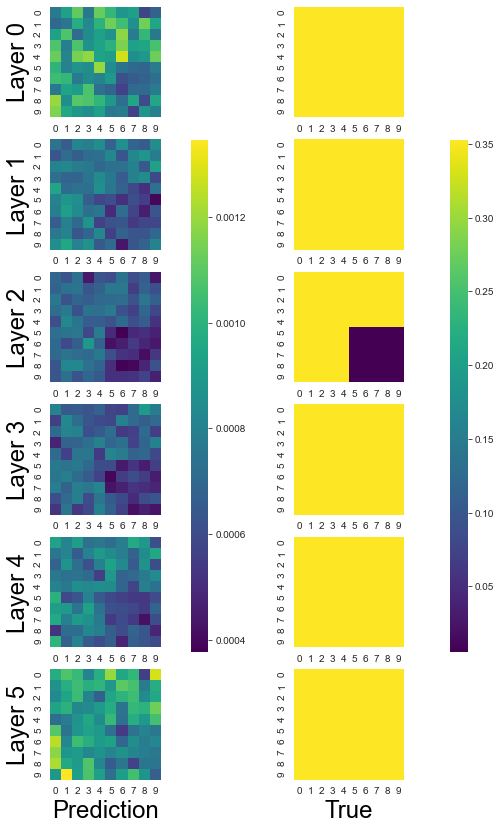

In [54]:
plot_pred_true_x0(*preds[0])

## Scatter pos

In [40]:
from tomopt.optimisation.callbacks import ScatterRecord

In [41]:
sr = ScatterRecord()
preds = wrapper.predict(PassiveYielder([arb_rad_length]), n_mu_per_volume=10000, mu_bs=100, use_default_pred=False, cbs=[sr])

In [90]:
df = sr.get_record(as_df=True)
df.describe()

,x,y,z,layer
count,5210.000000,5210.000000,5210.000000,5210.000000
mean,0.507676,0.511630,0.499481,2.500192
std,0.267215,0.268235,0.156030,1.546272
min,0.002796,0.003873,0.200051,0.000000
25%,0.278162,0.281665,0.378730,1.000000
50%,0.510631,0.526885,0.500842,2.000000
75%,0.739512,0.741061,0.622901,4.000000
max,0.996711,0.999996,0.799937,5.000000


In [91]:
df

,x,y,z,layer
0,0.908861,0.535088,0.264035,5
1,0.456261,0.681453,0.620696,1
2,0.536006,0.800899,0.438292,3
3,0.369398,0.280207,0.498652,3
4,0.934875,0.129899,0.292161,5
...,...,...,...,...
5205,0.688183,0.585195,0.201906,5
5206,0.793155,0.242687,0.507175,2
5207,0.368732,0.127515,0.741927,0
5208,0.621184,0.220397,0.425410,3


In [142]:
TK_SZ = 16
TK_COL = "black"
LBL_SZ = 24
LBL_COL = "black"
LEG_SZ = 16
CAT_PALETTE = "tab10"
STYLE = {"style": "whitegrid", "rc": {"patch.edgecolor": "none"}}
H_MID = 16


def plot_scatter_density(scatter_df: pd.DataFrame, savename: Optional[str] = None) -> None:
    with sns.axes_style(style="whitegrid", rc={"patch.edgecolor": "none"}):
        zs = sorted(scatter_df.layer.unique())
        n = len(zs)
        fig, axs = plt.subplots(n, 1, figsize=(H_MID/n, H_MID))
        for i, z in enumerate(zs):
            sns.histplot(data=scatter_df[(scatter_df.layer == z)], x="x", y="y", cmap="viridis", ax=axs[i], cbar=True)
            axs[i].set_ylabel(f"Layer {z}", fontsize=LBL_SZ, color=LBL_COL)
            axs[i].set_xlabel("", fontsize=LBL_SZ, color=LBL_COL)
        if savename is not None:
            plt.savefig(savename, bbox_inches="tight")
        plt.show()

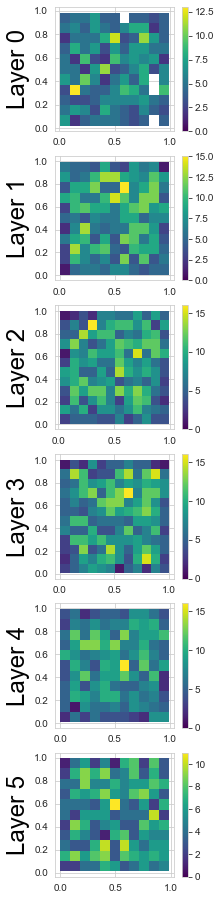

In [143]:
plot_scatter_density(scatter_df=df)

## Hits

In [229]:
class HitRecord(ScatterRecord):
    def on_scatter_end(self) -> None:
        hits = torch.stack([self.wrapper.fit_params.sb.xa0.detach().cpu().clone(),
                            self.wrapper.fit_params.sb.xa1.detach().cpu().clone(), 
                            self.wrapper.fit_params.sb.xb1.detach().cpu().clone(), 
                            self.wrapper.fit_params.sb.xb0.detach().cpu().clone()], dim=1)
        self.record.append(hits)
        
    def _to_df(self, record:Tensor)->pd.DataFrame:
        df = pd.DataFrame(record.reshape(-1, 3).numpy(), columns=["x", "y", "z"])
        df["layer"] = df.z.astype('category').cat.codes  # df ordered by reshapeing hits
        return df

In [230]:
hr = HitRecord()
preds = wrapper.predict(PassiveYielder([arb_rad_length]), n_mu_per_volume=10000, mu_bs=100, use_default_pred=False, cbs=[hr])

In [231]:
df = hr.get_record(as_df=True)
df.describe()

,x,y,z,layer
count,33780.000000,33780.000000,33780.000000,33780.000000
mean,0.495666,0.499775,0.500000,1.500000
std,0.271382,0.270866,0.403119,1.118051
min,0.000772,0.000067,0.050000,0.000000
25%,0.264342,0.269045,0.125000,0.750000
50%,0.491035,0.501431,0.500000,1.500000
75%,0.725587,0.728516,0.875000,2.250000
max,1.000000,0.999861,0.950000,3.000000


In [232]:
df

,x,y,z,layer
0,0.627097,0.655164,0.95,3
1,0.627584,0.652270,0.85,2
2,0.638591,0.629262,0.15,1
3,0.645776,0.626054,0.05,0
4,0.852912,0.512395,0.95,3
...,...,...,...,...
33775,0.051231,0.424240,0.05,0
33776,0.829791,0.456770,0.95,3
33777,0.834026,0.473018,0.85,2
33778,0.874727,0.583782,0.15,1


In [224]:
def plot_hit_density(hit_df:pd.DataFrame, savename: Optional[str] = None) -> None:
    plot_scatter_density(hit_df, savename)

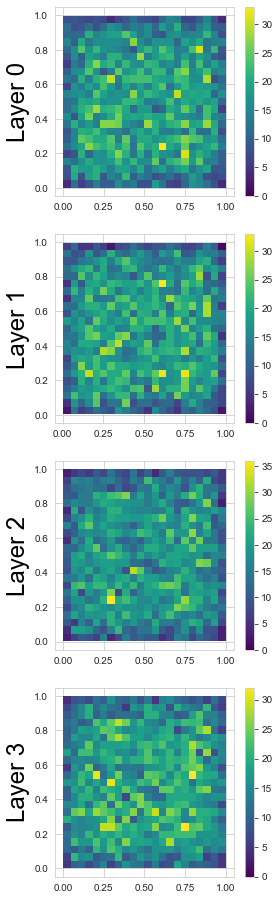

In [225]:
plot_hit_density(hit_df=df)

## Scatter-hit test

In [237]:
hr = HitRecord()
sr = ScatterRecord()
preds = wrapper.predict(PassiveYielder([arb_rad_length]), n_mu_per_volume=100000, mu_bs=100, use_default_pred=False, cbs=[hr, sr])

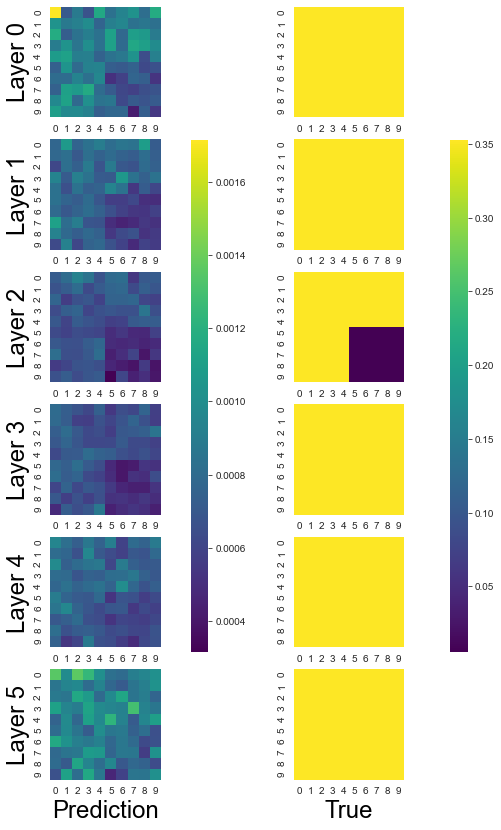

In [247]:
plot_pred_true_x0(*preds[0])

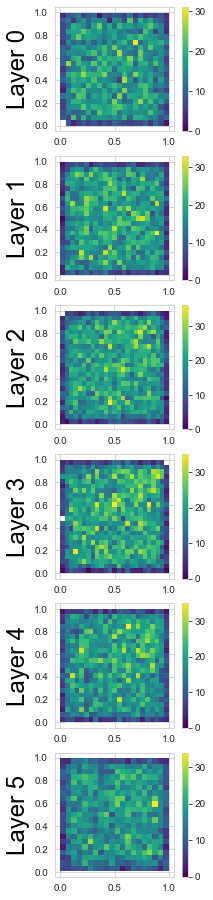

In [251]:
plot_scatter_density(sr.get_record(True))

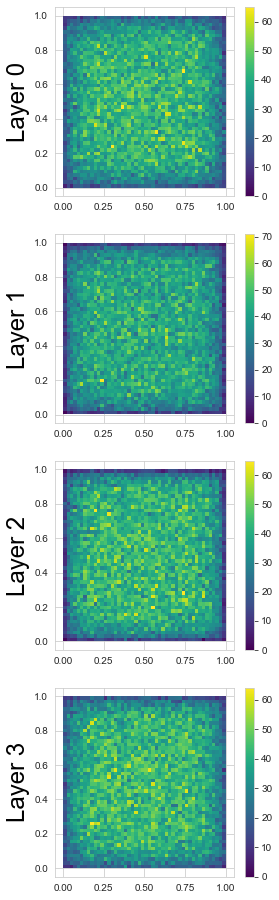

In [252]:
plot_hit_density(hr.get_record(True))